## DS7731 - Mini Lab (SVM Part)
Team: Amber, Jeremy, Lance, Shawn 

In [0]:
# load required libraries 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()
%matplotlib inline 


In [0]:
# import the telco churn data as dataframe named 'df'
url = 'https://raw.githubusercontent.com/jotsap/DS7331/master/data/churn.csv'
df = pd.read_csv(url)

In [0]:
# Let's check if it is loaded ok 
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [0]:
# create another placeholder dataframe df_impute for imputed features, and a series df_y to hold response variable 
df_impute = pd.DataFrame()
df_y = df['Churn'].map(dict(Yes=1, No=0))

In [0]:
# Date Impute - Numerical data 
df_impute['Tenure'] = df['tenure']
df_impute['MonthlyCharges'] = df['MonthlyCharges']
# As discussed in the ETA stage, fill missing values of TotalCharges as zero 
df['TotalCharges'] = df['TotalCharges'].replace(' ',0)
df_impute['TotalCharges'] = df['TotalCharges'].astype(float)

In [0]:
# converting binary categorical variables 
df_impute['FemaleYN'] = df['gender'].map(dict(Male=0, Female=1))
df_impute['Partner'] = df['Partner'].map(dict(Yes=1, No=0))
df_impute['Dependents'] = df['Dependents'].map(dict(Yes=1, No=0))
df_impute['PhoneService'] = df['PhoneService'].map(dict(Yes=1, No=0))
df_impute['SeniorCitizen'] = df['SeniorCitizen']

In [0]:
# encoding variables with multiple categories  
multi_category = ['MultipleLines', 'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies','Contract','PaperlessBilling','PaymentMethod']
multi_prefix = ['MLines', 'IService', 'OSecurity', 'OBackup', 'DProtection', 'TSupport','STV', 'SMovies','Contract','PBilling','PMethod']

for seq, category in enumerate(multi_category):
    # get the category from multi_category, and use the prefix from multi_prefix list 
    tmp_df = pd.get_dummies(df[category], multi_prefix[seq])
    # append to the df_impute dataframe
    df_impute = pd.concat((df_impute,tmp_df), axis=1)


In [0]:
df_impute.head()

,FemaleYN,Partner,Dependents,PhoneService,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges,MLines_No,MLines_No phone service,...,SMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PBilling_No,PBilling_Yes,PMethod_Bank transfer (automatic),PMethod_Credit card (automatic),PMethod_Electronic check,PMethod_Mailed check
0,1,1,0,0,0,1,29.85,29.85,0,1,...,0,1,0,0,0,1,0,0,1,0
1,0,0,0,1,0,34,56.95,1889.50,1,0,...,0,0,1,0,1,0,0,0,0,1
2,0,0,0,1,0,2,53.85,108.15,1,0,...,0,1,0,0,0,1,0,0,0,1
3,0,0,0,0,0,45,42.30,1840.75,0,1,...,0,0,1,0,1,0,1,0,0,0
4,1,0,0,1,0,2,70.70,151.65,1,0,...,0,1,0,0,0,1,0,0,1,0


In [0]:
tmp_df = pd.get_dummies(multi_category, prefix=multi_category)

In [0]:
tmp_df

,"['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']_Contract","['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']_DeviceProtection","['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']_InternetService","['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']_MultipleLines","['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']_OnlineBackup","['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']_OnlineSecurity","['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']_PaperlessBilling","['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']_PaymentMethod","['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']_StreamingMovies","['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']_StreamingTV","['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']_TechSupport"
0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,1,0
7,0,0,0,0,0,0,0,0,1,0,0
8,1,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,1,0,0,0,0


In [0]:
# cross validation shuffling 
from sklearn.model_selection import ShuffleSplit 

y = df_y.values # transform df_y into numpy matrix 
X = df_impute.values # the same with X 

# we will iterate thee CV, and train/test split ratio will be 8:2 
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations, test_size=0.2)

print(cv_object)


ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [0]:
# split train/test datasets based on CV split, and scale the data 
for train_indices, test_indices in cv_object.split(X,y):
    X_train = X[train_indices]
    y_train = y[train_indices]

    X_test = X[test_indices]
    y_test = y[test_indices]


In [0]:
# Let's scale the data. We will scale based on train data only to avoid snooping (keep test dataset intact from contamination)
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics as mt 

scl_obj = StandardScaler()
scl_obj.fit(X_train) 

X_train_scaled = scl_obj.transform(X_train)
X_test_scaled = scl_obj.transform(X_test) 

In [0]:
# Now we will play with SVM. As Professor advised, we will use kinda automated hyper parameter list generation with 'np.logspace'
from sklearn.svm import SVC 

c_values = np.logspace(-3.0, 2.0, num=14)
acc = []

for c in c_values:
    svm_clf = SVC(C=c, kernel='linear', degree=3, gamma='auto') 
    svm_clf.fit(X_train_scaled, y_train) # training 
    y_hat = svm_clf.predict(X_test_scaled) 
    acc_temp = mt.accuracy_score(y_test, y_hat) 
    print(acc_temp)
    acc.append(acc_temp)

# we will go with c

0.7991483321504613
0.8034066713981547
0.8019872249822569
0.8034066713981547
0.8041163946061036
0.8041163946061036
0.8041163946061036
0.8034066713981547
0.8055358410220014
0.8062455642299503
0.8069552874378992
0.8076650106458482
0.8069552874378992
0.8076650106458482


In [0]:
# we will select c_values[12] which showed the highest accuracy. We can later refine this hyper parameter selection part. 

svm_clf = SVC(C=c_values[12], kernel='linear', degree=3, gamma='auto') 
svm_clf.fit(X_train_scaled, y_train) # training 
y_hat = svm_clf.predict(X_test_scaled) 

In [0]:
acc = mt.accuracy_score(y_test, y_hat)
conf = mt.confusion_matrix(y_test, y_hat) 
print("accuracy: %f" % acc) 
print(conf)

accuracy: 0.806955
[[950  97]
 [175 187]]


In [0]:
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_)
print(svm_clf.coef_)


(2607, 41)
(2607,)
[1306 1301]
[[ 0.0150659   0.03327123 -0.06350264  0.01572175  0.06815638 -0.51683957
  -0.56176598 -0.3031134  -0.08050303 -0.01572175  0.09070809 -0.37375611
   0.42131788 -0.07863495  0.06612567 -0.07863495 -0.00191898  0.02979787
  -0.07863495  0.03651946  0.0251879  -0.07863495  0.0414388   0.07632809
  -0.07863495 -0.01313219 -0.05906785 -0.07863495  0.12517506 -0.05409351
  -0.07863495  0.12027358  0.05963222 -0.08988097  0.01539482 -0.04992592
   0.04992592 -0.04522431 -0.03896645  0.09708657 -0.0268665 ]]


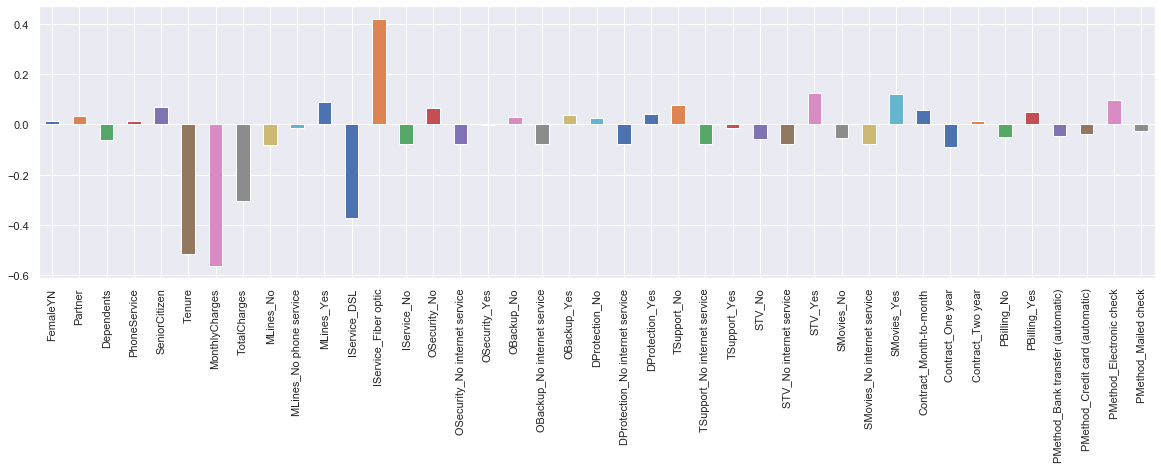

In [0]:
# How do we understand the weights from SVM training 
plt.figure(figsize=(20,5))
weights = pd.Series(svm_clf.coef_[0], index=df_impute.columns)
weights.plot(kind='bar')
